# UNet for image Segmentation

## Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split

## Loading image file names

In [2]:
filenames = os.listdir("train/images/")
train, test = train_test_split(filenames, test_size=0.1, shuffle = True)

## Ploting function
Plots both image and its corresponding mask

In [3]:
def plotSample(s):
    new_img = s["image"]
    new_mask = s["mask"]
    fig = plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(new_img[0, :, :], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(new_mask[0, :, :], cmap="gray")

    plt.show()

## Importing pytorch

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import jaccard_score

## Making DataLoader

- First creating a dataset class
- Then creating transforms to transform image and mask to pytorch tensors
- Lastly creating a Dataloader object

In [5]:
class segmentationData(Dataset):
    def __init__(self, image_dir, mask_dir, file_names, transforms = None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.files = file_names
        self.transforms = transforms
        self.length = len(file_names)
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, idx):
        img = cv2.imread(self.image_dir + self.files[idx], 0)
        mask = cv2.imread(self.mask_dir + self.files[idx], 0)
        img = cv2.copyMakeBorder(img, 14, 13, 14, 13, cv2.BORDER_CONSTANT, value=0)
        mask = cv2.copyMakeBorder(mask, 14, 13, 14, 13, cv2.BORDER_CONSTANT, value=0)
        img = np.expand_dims(img, axis=2)
        mask = np.expand_dims(mask, axis=2)
        sample = {"image" : img, "mask" : mask}
        
        if self.transforms:
            sample["image"] = self.transforms(sample["image"])
            sample["mask"] = self.transforms(sample["mask"])
            
        return sample

In [6]:
segDataTrain = segmentationData(image_dir="train/images/", mask_dir="train/masks/", 
                           file_names=train, transforms=transforms.Compose([transforms.ToTensor()]))

segDataTest = segmentationData(image_dir="train/images/", mask_dir="train/masks/", 
                           file_names=test, transforms=transforms.Compose([transforms.ToTensor()]))

Sample images from Dataset Class

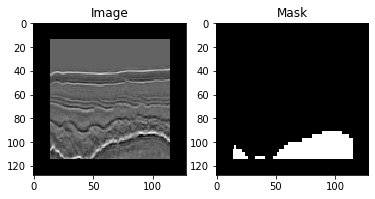

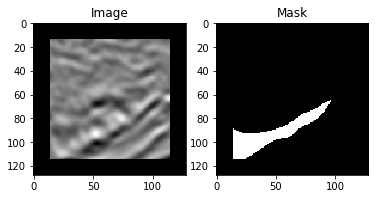

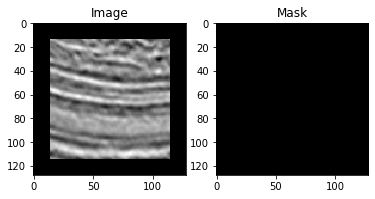

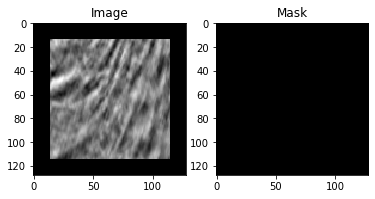

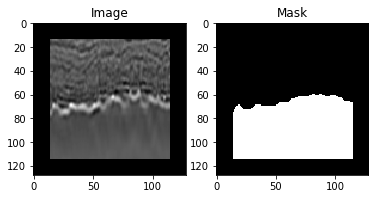

In [7]:
for i in range(10, 15):
    sam = segDataTrain[i]
    plotSample(sam)  

In [8]:
train_dataloader = DataLoader(segDataTrain, batch_size=30, shuffle=True, num_workers=0)
test_dataloader = DataLoader(segDataTest, batch_size=30, shuffle=True, num_workers=0)

## Coding Unet blocks

### Encoder block

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_channels, output_channels, maxpool_strides = 2, filters = 3):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=output_channels, kernel_size=filters, padding=1)
        self.conv2 = nn.Conv2d(in_channels=output_channels, out_channels=output_channels, kernel_size=filters, padding=1)
        self.activation = nn.ReLU()
        self.BatchNorm = nn.BatchNorm2d(output_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=maxpool_strides)
        
    def forward(self, x):
        l1 = self.activation(self.BatchNorm(self.conv1(x)))
        l1 = self.activation(self.BatchNorm(self.conv2(l1)))
        
        p1 = self.maxpool(l1)
        
        return l1, p1

### BottleNeck Block

In [10]:
class BottleNeck(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(BottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.BatchNorm = nn.BatchNorm2d(hidden_channels)
        
        self.up = nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=2, stride=2)
        
    def forward(self, x):
        l1 = self.activation(self.BatchNorm(self.conv1(x)))
        l1 = self.activation(self.BatchNorm(self.conv2(l1)))
        l1 = self.up(l1)
        return l1

### Decoder / Expansion Block

In [11]:
class Decoder(nn.Module):
    def __init__(self,input_channels, hidden_channels, output_channels, filters = 3):
        super(Decoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=hidden_channels, kernel_size=filters, padding=1)
        self.conv2 = nn.Conv2d(in_channels=hidden_channels, out_channels=hidden_channels, kernel_size=filters, padding=1)
        self.activation = nn.ReLU()
        self.BatchNorm = nn.BatchNorm2d(hidden_channels)
        self.up = nn.ConvTranspose2d(in_channels=hidden_channels, out_channels=output_channels, kernel_size=2, stride=2)
        
    def forward(self, up, com):
        x = torch.cat((up, com), 1)
        l1 = self.activation(self.BatchNorm(self.conv1(x)))
        l1 = self.activation(self.BatchNorm(self.conv2(l1)))
        l1 = self.up(l1)
        return l1

## Compiling and making whole UNet

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.enc1 = Encoder(1, 16)
        self.enc2 = Encoder(16, 32)
        self.enc3 = Encoder(32, 64)
        self.enc4 = Encoder(64, 128)
        self.bottle = BottleNeck(128, 256, 128)
        self.dec1 = Decoder(256, 128, 64)
        self.dec2 = Decoder(128, 64, 32)
        self.dec3 = Decoder(64, 32, 16)
        self.output = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=1)
        self.activate = nn.Sigmoid()
        
    def forward(self, inputs):
        c1, p = self.enc1(inputs)
        c2, p = self.enc2(p)
        c3, p = self.enc3(p)
        c4, p = self.enc4(p)
        u = self.bottle(p)
        u = self.dec1(u, c4)
        u = self.dec2(u, c3)
        u = self.dec3(u, c2)
        out = self.activate(self.output(u))
        
        return out

## Jaccard Index
The Jaccard index, also known as Intersection over Union and the Jaccard similarity coefficient (originally given the French name coefficient de communauté by Paul Jaccard), is a statistic used for gauging the similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection divided by the size of the union of the sample sets:

$$
\large J(A, B) = \frac {| A \cap B |} {|A \cup B |}
$$

$$
\large J(A, B) = \frac {| A \cap B |} {|A| + |B| - | A \cap B |}
$$

If A and B are both empty, we define J(A,B) = 1.

$$
0 \leq J(A, B) \leq 1
$$

In [13]:
def jscore(y_true, y_pred, avg = 'micro'):
    score = 0
    for i in range(len(y_true)):
        score += jaccard_score(y_true[i], y_pred[i], average=avg)
    return score / len(y_true)

In [14]:
unet = UNet()
criterion = nn.BCELoss()
opt = optim.Adam(unet.parameters(), lr = 0.00001, weight_decay=0.001)

In [15]:
unet = unet.cuda()
losses = []
score = []
with tqdm(total=40, desc="Epochs") as epochbar:
    for j in range(40):
        with tqdm(total=len(train_dataloader)) as pbar:
            l = 0
            for i, batch in enumerate(train_dataloader):
                images = batch["image"]
                masks = batch["mask"]
                images = images.cuda()
                masks = masks.cuda()
                outputs = unet(images)
                loss = criterion(outputs, masks)
                loss.backward()
                opt.step()
                l += loss.item()
                pbar.set_description("Running epoch " + str(j + 1) + " Loss : {:.3f}".format(loss.item()))
                pbar.update(1)
            losses.append(l / len(train_dataloader))
            #print(l / len(train_dataloader))
            
            
        with tqdm(total=len(test_dataloader)) as testbar:
            with torch.no_grad():
                jk = 0
                for k, batch in enumerate(test_dataloader):
                    o = unet(batch["image"].cuda())
                    bs = o.shape[0]
                    pred = o.cpu().view(bs, -1).numpy()
                    p = pred > 0.5
                    pred = p.astype(float)
                    orginal = batch["mask"].view(bs, -1).numpy()
                    jk += jscore(orginal, pred, avg='macro')
                    testbar.set_description("Running epoch " + str(j + 1) + " Jaccard Score : {:.3f}".format(jk / (k + 1)))
                    testbar.update(1)
                score.append(jk / len(test_dataloader))
        epochbar.set_description("Epochs, Average Loss : {:.3f}".format(l / len(train_dataloader)))       
        epochbar.update(1)

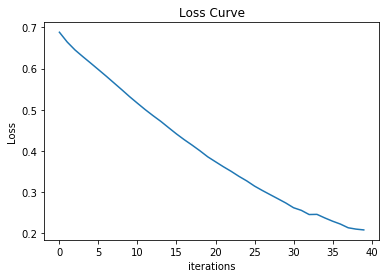

In [16]:
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.plot(list(range(len(losses))), losses)

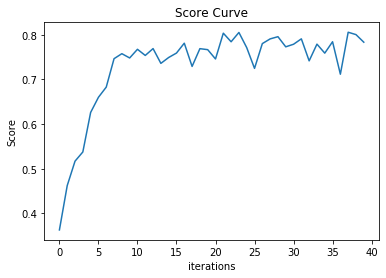

In [17]:
plt.xlabel("iterations")
plt.ylabel("Score")
plt.title("Score Curve")
plt.plot(list(range(len(score))), score)

In [18]:
def plotPredictions(s, pred):
    new_img = s["image"]
    new_mask = s["mask"]
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(new_img[0, :, :], cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Mask")
    plt.imshow(new_mask[0, :, :], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow(pred[0, :, :], cmap="gray")

    plt.show()

Result on Test Set


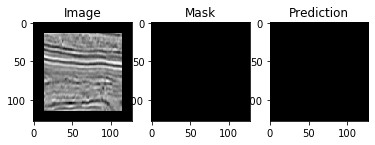

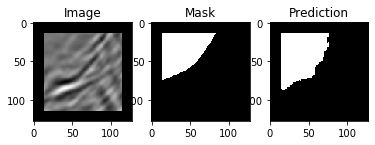

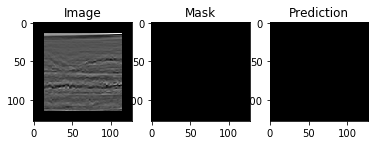

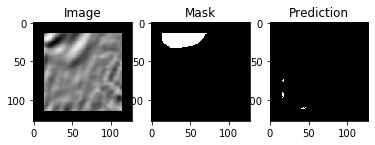

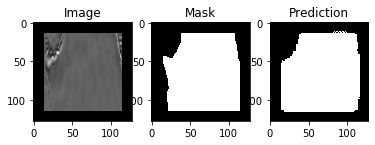

In [19]:
print("Result on Test Set")
with torch.no_grad():
    for k, batch in enumerate(test_dataloader):
        o = unet(batch["image"].cuda())
        bs = o.shape[0]
        pred1 = o.cpu().numpy()
        p = pred1 > 0.5
        pred1 = p.astype(float)
        break
        
for i in range(5, 10):
    sam = {"image" : batch["image"][i], "mask" : batch["mask"][i]}
    plotPredictions(sam, pred1[i]) 

Result on Train Set


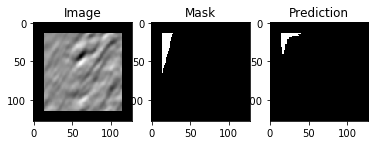

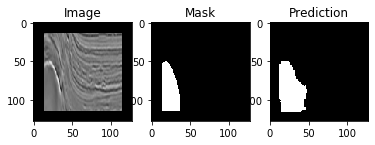

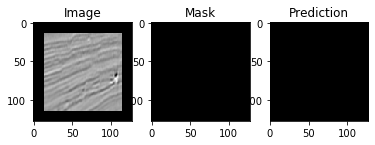

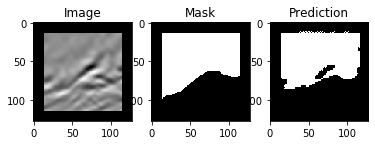

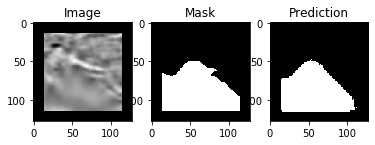

In [20]:
print("Result on Train Set")
with torch.no_grad():
    for k, batch in enumerate(train_dataloader):
        o = unet(batch["image"].cuda())
        bs = o.shape[0]
        pred2 = o.cpu().numpy()
        p = pred2 > 0.5
        pred2 = p.astype(float)
        break
        
for i in range(5, 10):
    sam = {"image" : batch["image"][i], "mask" : batch["mask"][i]}
    plotPredictions(sam, pred2[i]) 